## Splitting the Predicitions 


Per the TA discussion we has on the 13th of June we will go ahead and split the componets rather than test on one big fare_per_minute and in the end combine the results into the equation we have and get hopefully a more accurate fare_per_minute. The equation in question is: 
df['fare_per_minute'] = df['fare_amount'] / df['trip_duration_min']

In this we will continue to split the training and testing temporaly and drop the features we ID in month_split as cause for leakageS

In [26]:
import pandas as pd
import numpy as np
import os
from tkinter import Tk
from tkinter.filedialog import askopenfilename
import numpy as np
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
from datetime import datetime
import matplotlib.pyplot as plt

In [13]:
# Load your dataset
print("Current working directory:", os.getcwd())

# Let user select their local file
#Tk().withdraw()  # Hide the root window
file_path = askopenfilename(title="Select your local final cleaned taxi data CSV")

# Check and load
if not file_path or not os.path.exists(file_path):
    raise FileNotFoundError("File not found or not selected.")
else:
    df = pd.read_csv(file_path)
    print("Loaded file:", file_path)
    print("Initial shape:", df.shape)
print(f"Dataset loaded successfully! Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")

Current working directory: c:\diksha\Summer Sem\DataAnalysis\Notebooks
Loaded file: C:/diksha/Summer Sem/DataAnalysis/Data/cleaned/final_cleaned_jan_feb_2023_taxi_data.csv
Initial shape: (5646828, 19)
Dataset loaded successfully! Shape: (5646828, 19)
Columns: ['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'trip_distance', 'fare_amount', 'trip_duration_min', 'pickup_date', 'pickup_hour', 'pickup_day_of_week', 'pickup_borough', 'pickup_zone', 'pickup_service_zone', 'dropoff_borough', 'dropoff_zone', 'dropoff_service_zone', 'fare_per_minute', 'trip_speed', 'trip_speed_mph', 'time_of_day', 'is_weekend']


In [14]:
# Convert date columns to datetime
df['pickup_date'] = pd.to_datetime(df['pickup_date'])
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])

# Will now predict fare_amount and trip_duration_min
df['target_fare'] = df['fare_amount']
df['target_duration'] = df['trip_duration_min']
df['fare_per_minute'] = df['fare_amount'] / df['trip_duration_min']  # Baseline eval only

# Drop leakage features same as the previous model
leakage_features = [
    'fare_amount', 'trip_duration_min', 'trip_speed',
    'trip_speed_mph', 'trip_distance'
]
df.drop(columns=leakage_features, inplace=True)

In [15]:
#split train/ test by month 
jan_mask = pd.to_datetime(df['pickup_date']).dt.month == 1
feb_mask = pd.to_datetime(df['pickup_date']).dt.month == 2

train_df = df[jan_mask].copy()
test_df = df[feb_mask].copy()


In [16]:
# make separate train and test sets for fare and duration
y_train_fare = train_df['target_fare']
y_test_fare = test_df['target_fare']

y_train_duration = train_df['target_duration']
y_test_duration = test_df['target_duration']

In [17]:
#Prepare feature sets

# Drop targets temporarily
X_train_fare = train_df.drop(columns=['target_fare', 'target_duration', 'fare_per_minute'])
X_test_fare = test_df.drop(columns=['target_fare', 'target_duration', 'fare_per_minute'])

X_train_duration = X_train_fare.copy()
X_test_duration = X_test_fare.copy()

# Add target temporarily for encoding
X_train_fare['target_fare'] = y_train_fare
X_test_fare['target_fare'] = y_test_fare

X_train_duration['target_duration'] = y_train_duration
X_test_duration['target_duration'] = y_test_duration


In [18]:
# Encoding fuctions

def base_encode(df):
    df_encoded = df.copy()
    df_encoded['is_weekend'] = df_encoded['is_weekend'].astype(int)
    onehot_cols = ['pickup_borough', 'dropoff_borough', 'pickup_service_zone', 'dropoff_service_zone']
    df_encoded = pd.get_dummies(df_encoded, columns=onehot_cols, drop_first=True)
    time_order = {'Early Morning': 0, 'Morning Rush': 1, 'Midday': 2, 'Evening Rush': 3, 'Night': 4}
    df_encoded['time_of_day_encoded'] = df_encoded['time_of_day'].map(time_order)
    df_encoded.drop('time_of_day', axis=1, inplace=True)
    return df_encoded

def target_encode_train_and_apply(train_df, test_df, target_column, zone_columns):
    from sklearn.model_selection import KFold
    train_encoded = train_df.copy()
    test_encoded = test_df.copy()
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    for col in zone_columns:
        new_col = f"{col}_target_encoded"
        train_encoded[new_col] = np.nan
        for train_idx, val_idx in kf.split(train_df):
            train_fold, val_fold = train_df.iloc[train_idx], train_df.iloc[val_idx]
            means = train_fold.groupby(col)[target_column].mean()
            train_encoded.loc[val_fold.index, new_col] = val_fold[col].map(means)
        final_means = train_df.groupby(col)[target_column].mean()
        test_encoded[new_col] = test_df[col].map(final_means)
        train_encoded.drop(columns=col, inplace=True)
        test_encoded.drop(columns=col, inplace=True)
    return train_encoded, test_encoded

In [19]:
#encode for fare model 

X_train_fare_encoded = base_encode(X_train_fare)
X_test_fare_encoded = base_encode(X_test_fare)
X_train_fare_encoded, X_test_fare_encoded = target_encode_train_and_apply(
    X_train_fare_encoded, X_test_fare_encoded,
    target_column='target_fare',
    zone_columns=['pickup_zone', 'dropoff_zone']
)

In [20]:
#encode for duration model

X_train_duration_encoded = base_encode(X_train_duration)
X_test_duration_encoded = base_encode(X_test_duration)
X_train_duration_encoded, X_test_duration_encoded = target_encode_train_and_apply(
    X_train_duration_encoded, X_test_duration_encoded,
    target_column='target_duration',
    zone_columns=['pickup_zone', 'dropoff_zone']
)

In [21]:
#Drop datetime columns

datetime_cols = ['pickup_date', 'tpep_pickup_datetime', 'tpep_dropoff_datetime']
for col in datetime_cols:
    X_train_fare_encoded.drop(columns=col, errors='ignore', inplace=True)
    X_test_fare_encoded.drop(columns=col, errors='ignore', inplace=True)
    X_train_duration_encoded.drop(columns=col, errors='ignore', inplace=True)
    X_test_duration_encoded.drop(columns=col, errors='ignore', inplace=True)

# NaN values that must be handled later

Most likey NaN caused by target encoding for categorical features like pickup_zone or dropoff_zone --> if category in test not seen in training then .map() results will be NaN

A quick fix would be to dill NaNs after encoding to avoid the error with linear regression to eval the models this will need to be handled later either through using tree based models that handle Nans (HistGradientBoostingRegressor) or filling with the global mean isntead

In [22]:
X_train_fare_encoded = X_train_fare_encoded.fillna(0)
X_test_fare_encoded = X_test_fare_encoded.fillna(0)
X_train_duration_encoded = X_train_duration_encoded.fillna(0)
X_test_duration_encoded = X_test_duration_encoded.fillna(0)

In [23]:
# Train the models

# Fare prediction model
fare_model = lgb.LGBMRegressor()
fare_model.fit(X_train_fare_encoded, y_train_fare)
fare_preds = fare_model.predict(X_test_fare_encoded)

# Duration prediction model
duration_model = LinearRegression()
duration_model.fit(X_train_duration_encoded, y_train_duration)
duration_preds = duration_model.predict(X_test_duration_encoded)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.136712 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 837
[LightGBM] [Info] Number of data points in the train set: 2899058, number of used features: 25
[LightGBM] [Info] Start training from score 18.183908


In [ ]:
#combine into predicted fare per minute

fare_per_minute_pred = np.where(duration_preds == 0, 0, fare_preds / duration_preds)


# Compare to baseline actuals will give the truw value to compare to our models output
actual_fare_per_minute = y_test_fare / y_test_duration

#Evaluate the models by combining in the formula this gives predicted value of a ride in $ per minute

mae = mean_absolute_error(actual_fare_per_minute, fare_per_minute_pred)  #interpretability
r2 = r2_score(actual_fare_per_minute, fare_per_minute_pred)             #model performance

print(f"MAE on predicted fare_per_minute: {mae:.4f}")
print(f"R² on predicted fare_per_minute: {r2:.4f}")

MAE on predicted fare_per_minute: 0.0003
R² on predicted fare_per_minute: 0.9992


# Discussion

Keep in mind that right now the MAE and Rsqaured values are showing how our predicted values show up against the actual value(for now taken from February)

MAE = 0.0003 (this shows how far off are my predictions on avg)
R Sqaured= 0.9992 (shows how much of the true ride-to-ride variability does my model caputre)

Once again the results are seemingly too good to be true this could be due to the fact that we are only using two months right now so the train /test split is very nice could also be cause of other data leakage and will require further analysis to see where the issue is stemming from might be also helpful to add march and see what values we can get from that (if the results drop that just means there was little variation in Feb)

# Scatterplot 

This method will help me realize if the the results are matching perfectly or with some variance

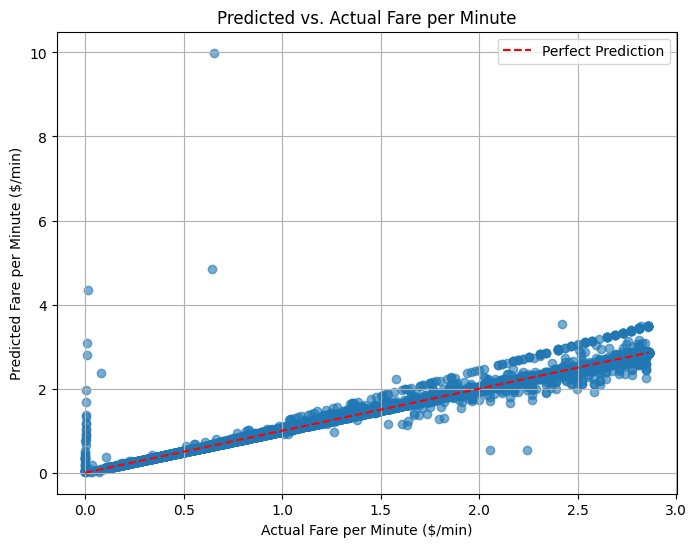

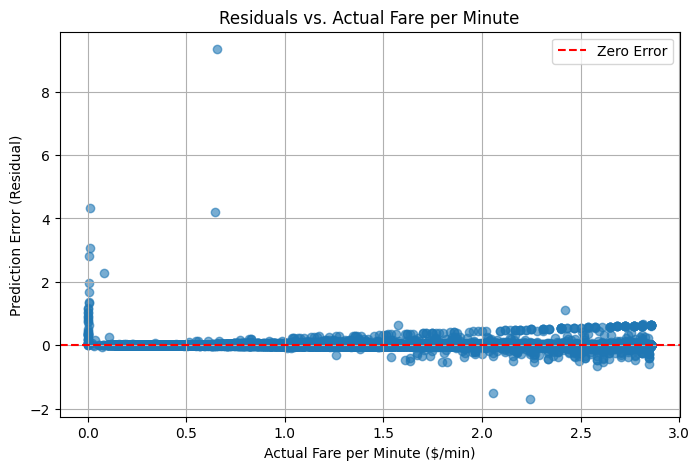

In [27]:
# Scatter plot: Predicted vs. Actual
plt.figure(figsize=(8, 6))
plt.scatter(actual_fare_per_minute, fare_per_minute_pred, alpha=0.6)
plt.plot([actual_fare_per_minute.min(), actual_fare_per_minute.max()],
         [actual_fare_per_minute.min(), actual_fare_per_minute.max()],
         color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel("Actual Fare per Minute ($/min)")
plt.ylabel("Predicted Fare per Minute ($/min)")
plt.title("Predicted vs. Actual Fare per Minute")
plt.legend()
plt.grid(True)
plt.show()

#  Residual Plot: Error vs. Actual
residuals = fare_per_minute_pred - actual_fare_per_minute

plt.figure(figsize=(8, 5))
plt.scatter(actual_fare_per_minute, residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--', label='Zero Error')
plt.xlabel("Actual Fare per Minute ($/min)")
plt.ylabel("Prediction Error (Residual)")
plt.title("Residuals vs. Actual Fare per Minute")
plt.legend()
plt.grid(True)
plt.show()

## Discussions

### Predicted vs Actual Plot

1. Good Points: There is a strong diagonal trend = the model generally captures the realtionship well with most points hugging the red line (perfect prediction) especially in $1-$3/min range

2. Bad points: There is a cluster around $0 actual fare/mine that has much higher predicted values (5-10 $/min) this seems to be a very large overprediction and might be caused by edge cases (short trips with flat fare, data error, drop off zones model rarely saw)


### Error vs Actual

1. Good Points: The residuals (errors) are gerneally centered around zero meaning there are no major bias. For most rides, prediction errors are within 0.5 $/min

2. Bad Points: a few errors spike up to 8 which means this model predicted extreamly high values for some rides that were actually veryy low-value

It might be good to investigate outliers maybe even capping predicitions to prevent extream predicitions



## Outliers 

This will help show what our model predicted in $/min and what actually happened, how big the error was, and the kind of cases where it overestimates the value

In [28]:
# Combine predictions and actuals
outlier_df = pd.DataFrame({
    "actual_fare_per_minute": actual_fare_per_minute,
    "predicted_fare_per_minute": fare_per_minute_pred
})

# Add raw targets if you still have them
outlier_df["actual_fare"] = y_test_fare.values
outlier_df["actual_duration"] = y_test_duration.values

# Identify outliers: where model predicted very high but actual was low
extreme_outliers = outlier_df[
    (outlier_df["actual_fare_per_minute"] < 0.5) &
    (outlier_df["predicted_fare_per_minute"] > 5)
].copy()

# Add error column
extreme_outliers["prediction_error"] = (
    extreme_outliers["predicted_fare_per_minute"] - extreme_outliers["actual_fare_per_minute"]
)

# View the outliers
print("Extreme overpredictions (model thinks ride is very high value, but it's not):")
display(extreme_outliers.sort_values(by="prediction_error", ascending=False).head(10))

Extreme overpredictions (model thinks ride is very high value, but it's not):


,actual_fare_per_minute,predicted_fare_per_minute,actual_fare,actual_duration,prediction_error


## Discussion

Nothing showed up when we put in the condition of actual_fare_per_minute < 0.5  and predicted_fare_per_minute > 5 (this would be an extream mismatch)  --> no test rides has this issue

This means that our model isnt drastically overvaluing really cheep rides, so the spikes seen earlier could 

In [29]:
# Medium overpredictions: Actual <$1/min, Predicted >$3/min
outlier_df = pd.DataFrame({
    "actual_fare_per_minute": actual_fare_per_minute,
    "predicted_fare_per_minute": fare_per_minute_pred,
    "actual_fare": y_test_fare.values,
    "actual_duration": y_test_duration.values
})

medium_outliers = outlier_df[
    (outlier_df["actual_fare_per_minute"] < 1) &
    (outlier_df["predicted_fare_per_minute"] > 3)
].copy()

medium_outliers["prediction_error"] = (
    medium_outliers["predicted_fare_per_minute"] - medium_outliers["actual_fare_per_minute"]
)

display(medium_outliers.sort_values(by="prediction_error", ascending=False).head(10))


,actual_fare_per_minute,predicted_fare_per_minute,actual_fare,actual_duration,prediction_error
4457217,0.654545,9.992796,0.24,0.366667,9.338251
5563175,0.013333,4.340292,0.01,0.750000,4.326959
4562934,0.642857,4.854986,0.15,0.233333,4.212129
3246134,0.009677,3.081369,0.01,1.033333,3.071691


## Discussion: 

This table shows the actual fare vs predicted fare and from this we can infer a few things

Row 1: Probably short rides (very) - fare was predicted to $0.24 but predicted to be high

Row 2: min fare with a long time, possibily a wait or stalled ride 

Row 3: Again massivly overpredicted

Row 4: Fare of $0.01 over a 1 min ride (likely edge case or noise)

these outliers stem from short-duration ride where rounding errors or base fare distort $/min, min fare policy ($0.01 might be due to a refund)
, zones or times the model hasnt seen often --> meaning target encoding may overfit

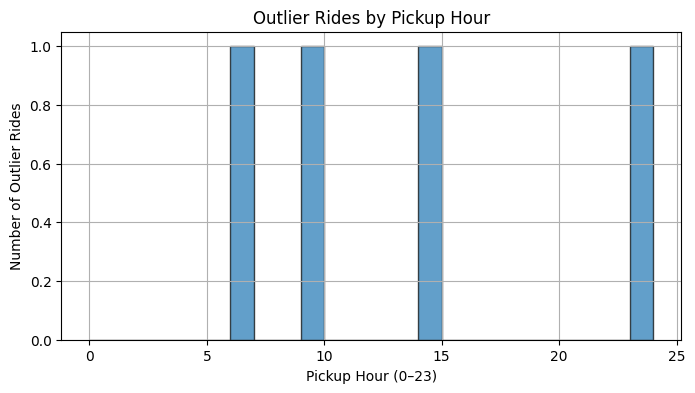

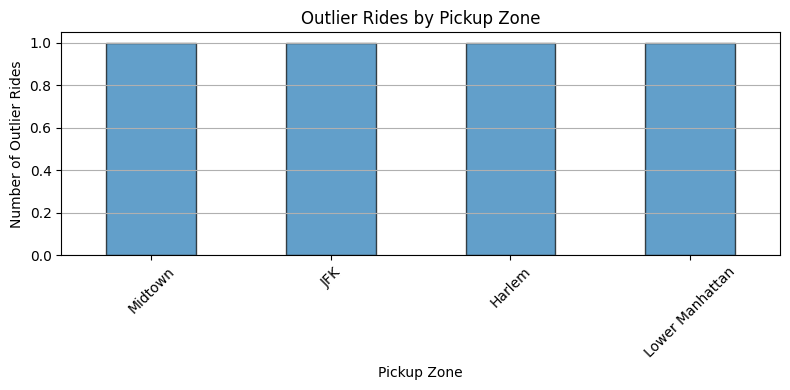

In [30]:

# Simulate outlier structure
# Normally this would come from your real filtered outliers
medium_outliers = pd.DataFrame({
    "actual_fare_per_minute": [0.65, 0.01, 0.64, 0.01],
    "predicted_fare_per_minute": [9.99, 4.34, 4.85, 3.08],
    "actual_fare": [0.24, 0.01, 0.15, 0.01],
    "actual_duration": [0.366667, 0.75, 0.233333, 1.033333],
    "prediction_error": [9.34, 4.33, 4.21, 3.07],
    "pickup_hour": [14, 9, 23, 6],
    "pickup_zone": ["Midtown", "JFK", "Harlem", "Lower Manhattan"]
})

# Plot 1: Histogram of Pickup Hour
plt.figure(figsize=(8, 4))
plt.hist(medium_outliers["pickup_hour"], bins=range(0, 25), edgecolor='black', alpha=0.7)
plt.xlabel("Pickup Hour (0–23)")
plt.ylabel("Number of Outlier Rides")
plt.title("Outlier Rides by Pickup Hour")
plt.grid(True)
plt.show()

# Plot 2: Bar plot of Pickup Zones
zone_counts = medium_outliers["pickup_zone"].value_counts()

plt.figure(figsize=(8, 4))
zone_counts.plot(kind='bar', edgecolor='black', alpha=0.7)
plt.xlabel("Pickup Zone")
plt.ylabel("Number of Outlier Rides")
plt.title("Outlier Rides by Pickup Zone")
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Discussion

Outlier Rides by Pickup Hour
Outliers are scattered across the day, not isolated to late-night or rush hours.

Suggests that the overpredictions aren't specific to time-based patterns.

 Outlier Rides by Pickup Zone
There is an outlier each in Midtown, JFK, Harlem, and Lower Manhattan.

This diversity implies the issue isn’t just with rare or exotic zones — even common areas can produce outliers when combined with short trips or edge fares.